# Simple ReAct Agent (PreBuilt) With Tools Usage

Imports

In [1]:
from typing import Annotated
from langchain_core.tools import tool

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

from langgraph.graph import MessagesState
from langchain.chat_models import init_chat_model
from langchain.tools.retriever import create_retriever_tool
from typing import List

from langchain_core.tools import tool
from langchain_ollama import ChatOllama

from langgraph.graph import MessagesState
from langchain.chat_models import init_chat_model

from pydantic import BaseModel, Field
from typing import Literal

from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

from IPython.display import Image, display
from typing_extensions import TypedDict

from langgraph.graph.message import add_messages
from typing import Annotated




Defining Tools

In [2]:
import math

@tool
def multiply(a: int, b: int) -> int:
    """Multiply two numbers."""
    return a * b

@tool
def estimate_wear(T_measured: float, T_sharp: float, beta: float) -> float:
    """
    This tool allows you to estimate the wear on a drilling piece. 

    Please always use this tool when asked about wear of drill.
    """
    W = (T_measured - T_sharp) / (beta * T_sharp)
    return max(0.0, min(W, 1.0))

@tool(return_direct=True)
def compute_sharp_torque(C2: float, R : float, f: float, w: float, p_deg:float, b:float) -> float:
    """
    This tool allows you to estimate the torque of a drilling piece.

    Always use this tool when asled about torque.
    """
    p_rad = math.radians(p_deg)
    sin2_p = math.sin(p_rad)**2

    term1 = (C2 * (R**2) * f) / (b + 2)
    term2 = C2 * f * (w**2) * sin2_p

    return term1 + term2 

Example on How to invoke just the tools

In [3]:

print(multiply.invoke({"a": 6, "b": 7}))  # returns 42

print(estimate_wear.invoke({"T_measured": 1, "T_sharp": 0.5, "beta": 2}))
# should return 0.5


42
0.5


# Creating the Agent

For this file, the default ReAct agent from langgraph is used.
This because, initially we just want to have 1 LLM that accesses the tools. 

If Multi-Agent or Mixture of Experts is needed, then we will construct our own agents.

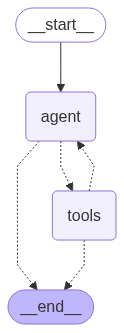

{'messages': [HumanMessage(content="what's 42 x 7?", additional_kwargs={}, response_metadata={}, id='52221d30-931d-44b7-a484-0e3e7347b6db'), AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2025-07-10T12:54:30.674302889Z', 'done': True, 'done_reason': 'stop', 'total_duration': 8314615578, 'load_duration': 17296586, 'prompt_eval_count': 387, 'prompt_eval_duration': 6861124931, 'eval_count': 22, 'eval_duration': 1434335466, 'model_name': 'llama3.2'}, id='run--485deb93-7ae7-4ea5-b3a0-e4a02fd4980c-0', tool_calls=[{'name': 'multiply', 'args': {'a': '42', 'b': '7'}, 'id': '2895d5fb-b41a-47aa-862b-3bdb6039009c', 'type': 'tool_call'}], usage_metadata={'input_tokens': 387, 'output_tokens': 22, 'total_tokens': 409}), ToolMessage(content='294', name='multiply', id='202b2ac1-bde2-4026-a597-5f08e7f4f9a0', tool_call_id='2895d5fb-b41a-47aa-862b-3bdb6039009c'), AIMessage(content='The answer to the original question is: 42 × 7 = 294.', additional_kwargs

In [22]:
from langgraph.prebuilt import create_react_agent


model = init_chat_model(
    model_provider="ollama",
    model="llama3.2",
    temperature = 0,
)

agent = create_react_agent(
    model=model,
    tools=[multiply, estimate_wear, compute_sharp_torque]
)

display(Image(agent.get_graph().draw_mermaid_png()))
response = agent.invoke({"messages": [{"role": "user", "content": "what's 42 x 7?"}]})
print(response)
response2 = agent.invoke({"messages": 
              [{"role": "user", 
                "content": "I want to estimate the wear of my model. I know that the value of T_meassured is 2.0, for T_sharp is 1.0 and for beta is 2.0"}
                ]})
print(response2)

In [23]:
print(response['messages'])
for i in range(0, len(response['messages'])):
    print(response['messages'][i])

print("###")
for i in range(0, len(response2['messages'])):
    print(response2['messages'][i])

[HumanMessage(content="what's 42 x 7?", additional_kwargs={}, response_metadata={}, id='52221d30-931d-44b7-a484-0e3e7347b6db'), AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2025-07-10T12:54:30.674302889Z', 'done': True, 'done_reason': 'stop', 'total_duration': 8314615578, 'load_duration': 17296586, 'prompt_eval_count': 387, 'prompt_eval_duration': 6861124931, 'eval_count': 22, 'eval_duration': 1434335466, 'model_name': 'llama3.2'}, id='run--485deb93-7ae7-4ea5-b3a0-e4a02fd4980c-0', tool_calls=[{'name': 'multiply', 'args': {'a': '42', 'b': '7'}, 'id': '2895d5fb-b41a-47aa-862b-3bdb6039009c', 'type': 'tool_call'}], usage_metadata={'input_tokens': 387, 'output_tokens': 22, 'total_tokens': 409}), ToolMessage(content='294', name='multiply', id='202b2ac1-bde2-4026-a597-5f08e7f4f9a0', tool_call_id='2895d5fb-b41a-47aa-862b-3bdb6039009c'), AIMessage(content='The answer to the original question is: 42 × 7 = 294.', additional_kwargs={}, response

In [11]:
def stream_graph_updates(user_input: str):
    for event in agent.invoke({"messages": [{"role": "user", "content": user_input}]}):
        print(event)
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

messages
User: What do you know about LangGraph?


KeyboardInterrupt: 